# IPL Score Predictor - Dynamic Run Rate Implementation

This notebook implements the IPL score prediction model with dynamic weighted run rate calculation for improved predictions.

## Setup and Imports

In [1]:
# Uncomment to install required packages
# %pip install pandas numpy torch matplotlib scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ML imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Enable debugging
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('IPLScorePredictor')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")
if device.type == 'cuda':
    logger.info(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    logger.info(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

2025-05-07 09:21:24,193 - INFO - Using device: cuda
2025-05-07 09:21:24,209 - INFO - CUDA Device: NVIDIA GeForce MX350
2025-05-07 09:21:24,210 - INFO - CUDA Memory Allocated: 0.00 MB


## Dynamic Weighted Run Rate Implementation

In [3]:
def calculate_weighted_run_rate(dataframe, alpha=0.7):
    """Calculate weighted run rate based on previous overs with an exponential weighting.
    
    Args:
        dataframe: Pandas DataFrame containing match data
        alpha: Weight for current run rate (higher value gives more weight to current run rate)
        
    Returns:
        DataFrame with added weighted_run_rate column
    """
    logger.info(f"Calculating weighted run rate with alpha={alpha}")
    
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()
    
    # Calculate per-over run rate
    df['curr_run_rate'] = df['total_runs']
    
    # Initialize column for weighted run rate
    df['weighted_run_rate'] = 0.0
    
    # Process each match and inning separately
    match_innings_groups = df.groupby(['match_id', 'inning'])
    logger.info(f"Processing {len(match_innings_groups)} match-inning combinations")
    
    for (match_id, inning), group in match_innings_groups:
        # Sort by over to ensure correct sequence
        group = group.sort_values('over')
        
        # Initialize weighted run rate with the first over's run rate
        weighted_rr = group['curr_run_rate'].iloc[0]
        
        # Process each row and update the weighted run rate
        for idx, row in group.iterrows():
            if row['over'] == 1:  # First over - just use its run rate
                df.at[idx, 'weighted_run_rate'] = row['curr_run_rate']
            else:
                # Apply the formula: α(RR_current) + (1-α)(RR_previous_weighted)
                weighted_rr = alpha * row['curr_run_rate'] + (1-alpha) * weighted_rr
                df.at[idx, 'weighted_run_rate'] = weighted_rr
    
    # Round for readability
    df['weighted_run_rate'] = df['weighted_run_rate'].round(2)
    
    # Sort the dataframe for readability
    df = df.sort_values(['match_id', 'inning', 'over'])
    
    logger.info("Weighted run rate calculation completed")
    return df

## Data Processing and Preparation

In [4]:
def process_and_prepare_data(input_path='cleaned_data/updated_over_by_over_data_set.csv', 
                           output_path='cleaned_data/weighted_run_rate_dataset.csv',
                           alpha=0.9,
                           test_size=0.2,
                           random_state=42):
    """Main function to process data and prepare it for modeling.
    
    Args:
        input_path: Path to input CSV file
        output_path: Path to save processed data
        alpha: Weight parameter for weighted run rate
        test_size: Proportion of data for testing
        random_state: Random seed for reproducibility
        
    Returns:
        Processed data and necessary components for model training
    """
    # Load the dataset
    logger.info(f"Loading data from {input_path}")
    try:
        df = pd.read_csv(input_path)
        logger.info(f"Loaded data with shape: {df.shape}")
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None
    
    # Calculate weighted run rate
    df = calculate_weighted_run_rate(df, alpha=alpha)
    
    # Save the processed data
    logger.info(f"Saving processed data to {output_path}")
    df.to_csv(output_path, index=False)
    logger.info(f"Data saved successfully. Shape: {df.shape}")
    
    # Process season information
    df['season'] = df['season'].astype(str)
    df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]))
    
    # Encode teams
    team_encoder = LabelEncoder()
    df['batting_team'] = team_encoder.fit_transform(df['batting_team'])
    df['bowling_team'] = team_encoder.transform(df['bowling_team'])
    logger.info(f"Encoded {len(team_encoder.classes_)} unique teams")
    
    # Define and scale numerical features
    numerical_features = ['over', 'curr_run_rate', 'req_runrate', 'target_left', 'weighted_run_rate']
    scaler = StandardScaler()
    df_numerical = pd.DataFrame(
        scaler.fit_transform(df[numerical_features]), 
        columns=numerical_features
    )
    logger.info(f"Scaled {len(numerical_features)} numerical features")
    
    # Split by match_id to keep all overs of a match together
    match_ids = df['match_id'].unique()
    train_match_ids, test_match_ids = train_test_split(
        match_ids, test_size=test_size, random_state=random_state
    )
    
    train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
    test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)
    
    # Create index mappings for dataset creation
    train_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(train_df.index)}
    test_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(test_df.index)}
    
    logger.info(f"Training set: {len(train_df)} rows, {len(train_match_ids)} matches")
    logger.info(f"Testing set: {len(test_df)} rows, {len(test_match_ids)} matches")
    
    # Prepare numerical data for train and test sets
    train_numerical_data = scaler.transform(train_df[numerical_features])
    test_numerical_data = scaler.transform(test_df[numerical_features])
    
    # Display sample data for verification
    print("\nSample data (first 5 rows):")
    display_cols = ['match_id', 'inning', 'over', 'total_runs', 'weighted_run_rate']
    print(df[display_cols].head())
    
    # Display sample match for weighted run rate evolution
    sample_match_id = df['match_id'].unique()[0]
    sample_data = df[df['match_id'] == sample_match_id].sort_values(['inning', 'over'])
    print(f"\nWeighted Run Rate Evolution for Match {sample_match_id}:")
    display_cols = ['inning', 'over', 'total_runs', 'run_rate', 'curr_run_rate', 'weighted_run_rate']
    print(sample_data[display_cols])
    
    return {
        'processed_df': df,
        'train_df': train_df,
        'test_df': test_df,
        'train_numerical_data': train_numerical_data,
        'test_numerical_data': test_numerical_data,
        'train_index_map': train_index_map,
        'test_index_map': test_index_map,
        'team_encoder': team_encoder,
        'scaler': scaler,
        'numerical_features': numerical_features
    }

## Dataset Implementation for IPL Matches

In [5]:
class IPLMatchDataset(Dataset):
    """PyTorch Dataset for IPL match data with dynamic run rate.
    
    This class prepares match data for sequence prediction, organizing data
    by matches and building sequences of overs for each match.
    """
    
    def __init__(self, df, numerical_data, index_map, target_cols=None, sequence=True):
        """Initialize the dataset.
        
        Args:
            df: DataFrame containing match data
            numerical_data: Normalized numerical features
            index_map: Mapping from original to new indices
            target_cols: List of column names to use as targets
            sequence: Whether to use sequence mode (True) or single over mode (False)
        """
        self.df = df
        self.numerical_data = numerical_data
        self.index_map = index_map
        self.sequence = sequence
        
        # Default target columns if none specified
        if target_cols is None:
            self.target_cols = ['total_runs', 'is_wicket']
        else:
            self.target_cols = target_cols
            
        logger.info(f"Initializing dataset with {len(df)} records, target columns: {self.target_cols}")
        
        # Group by match_id and inning to build sequences
        if self.sequence:
            self.match_innings = list(df.groupby(['match_id', 'inning']))
            logger.info(f"Created {len(self.match_innings)} match-inning sequences")
        else:
            self.match_innings = None
    
    def __len__(self):
        """Return the number of items in the dataset."""
        if self.sequence:
            return len(self.match_innings)
        return len(self.df)
    
    def __getitem__(self, idx):
        """Get a data item.
        
        In sequence mode, returns data for all overs of a match-inning.
        In single mode, returns data for a single over.
        
        Args:
            idx: Index of the item to retrieve
            
        Returns:
            Features and targets for the requested item
        """
        if self.sequence:
            # Get all overs for this match-inning
            _, group = self.match_innings[idx]
            group = group.sort_values('over')  # Ensure correct order
            
            # Get features
            features = []
            for _, row in group.iterrows():
                # Map original index to the index in numerical_data
                mapped_idx = self.index_map[row.name]
                numerical_features = torch.tensor(self.numerical_data[mapped_idx], dtype=torch.float32)
                
                # Add team encodings
                batting_team = torch.tensor([row['batting_team']], dtype=torch.float32)
                bowling_team = torch.tensor([row['bowling_team']], dtype=torch.float32)
                
                # Combine features
                combined = torch.cat([numerical_features, batting_team, bowling_team])
                features.append(combined)
            
            # Stack features to create sequence
            features = torch.stack(features)
            
            # Get targets for the sequence
            targets = torch.tensor([group[col].values[-1] for col in self.target_cols], dtype=torch.float32)
            sequence_length = torch.tensor(len(group), dtype=torch.int32)
            
            return features, targets, sequence_length
        else:
            # Single over mode
            row = self.df.iloc[idx]
            mapped_idx = self.index_map[row.name]
            
            # Get features
            numerical_features = torch.tensor(self.numerical_data[mapped_idx], dtype=torch.float32)
            batting_team = torch.tensor([row['batting_team']], dtype=torch.float32)
            bowling_team = torch.tensor([row['bowling_team']], dtype=torch.float32)
            features = torch.cat([numerical_features, batting_team, bowling_team])
            
            # Get targets
            targets = torch.tensor([row[col] for col in self.target_cols], dtype=torch.float32)
            
            return features, targets

## Neural Network Model for IPL Score Prediction

In [6]:
class IPLScorePredictor(nn.Module):
    """Neural network model for predicting IPL match scores with dynamic run rate.
    
    This model uses LSTM layers to process sequence data and predict
    final scores and wickets.
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, output_size=2):
        """Initialize the model.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of LSTM hidden layers
            num_layers: Number of LSTM layers
            dropout: Dropout probability
            output_size: Size of output (typically 2 for runs and wickets)
        """
        super(IPLScorePredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers for prediction
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        logger.info(
            f"Initialized model: input_size={input_size}, "
            f"hidden_size={hidden_size}, num_layers={num_layers}, "
            f"dropout={dropout}, output_size={output_size}"
        )
    
    def forward(self, x, seq_lengths=None):
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            seq_lengths: Actual sequence lengths for each item in the batch
            
        Returns:
            Predicted scores with runs as direct values and wickets as logits
        """
        batch_size = x.size(0)
        
        # Pack padded sequence if sequence lengths are provided
        if seq_lengths is not None:
            # Pack the sequence to handle variable length sequences efficiently
            from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        
        # Forward through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Unpack if we packed earlier
        if seq_lengths is not None:
            out, _ = pad_packed_sequence(out, batch_first=True)
            
            # Use the last valid output for each sequence based on its length
            # Convert seq_lengths to indices tensor of correct type
            indices = (seq_lengths - 1).view(-1, 1).expand(batch_size, self.hidden_size)
            indices = indices.unsqueeze(1).to(torch.int64).to(x.data.device)
            out = out.gather(1, indices).squeeze(1)
        else:
            # Use the output from the last time step if no sequence lengths
            out = out[:, -1, :]
        
        # Forward through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # Output contains both runs prediction and wicket logits
        
        return out

## Custom Loss Function for Multi-task Learning

In [7]:
class CombinedIPLLoss(nn.Module):
    """Custom loss function for IPL score prediction that combines MSE for runs and BCE for wickets.
    
    This loss function handles the multi-task nature of the problem by applying appropriate
    loss functions to each component of the prediction.
    """
    def __init__(self, runs_weight=1.0, wicket_weight=1.0):
        """Initialize the combined loss function.
        
        Args:
            runs_weight: Weight for the runs prediction loss
            wicket_weight: Weight for the wicket prediction loss
        """
        super(CombinedIPLLoss, self).__init__()
        self.runs_weight = runs_weight
        self.wicket_weight = wicket_weight
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Includes sigmoid activation
        logger.info(f"Initialized Combined IPL Loss with weights - Runs: {runs_weight}, Wickets: {wicket_weight}")
    
    def forward(self, y_pred, y_true):
        """Calculate the combined loss.
        
        Args:
            y_pred: Model predictions with shape (batch_size, 2)
                   where [:, 0] are runs predictions and [:, 1] are wicket logits
            y_true: Ground truth values with shape (batch_size, 2)
                   where [:, 0] are actual runs and [:, 1] are binary wicket indicators
            
        Returns:
            Combined weighted loss
        """
        # Extract run and wicket components
        run_pred = y_pred[:, 0]  # Runs are direct predictions
        wicket_pred = y_pred[:, 1]  # Wicket predictions as logits
        
        run_true = y_true[:, 0]  # Actual runs
        wicket_true = y_true[:, 1]  # Actual wickets (0 or 1)
        
        # Calculate individual losses
        run_loss = self.mse_loss(run_pred, run_true)
        wicket_loss = self.bce_loss(wicket_pred, wicket_true)
        
        # Combine losses with weights
        combined_loss = self.runs_weight * run_loss + self.wicket_weight * wicket_loss
        
        return combined_loss, run_loss, wicket_loss

## Training Function with Dynamic Run Rate

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
              num_epochs=50, patience=10, verbose=True, sequence=True,
              save_path='best_ipl_model.pth'):
    """Train the neural network model.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function (combined loss for runs and wickets)
        optimizer: Optimization algorithm
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience (epochs without improvement)
        verbose: Whether to print progress
        sequence: Whether the data is in sequence mode
        save_path: Path to save the best model
        
    Returns:
        Trained model and training history
    """
    logger.info(f"Starting training for {num_epochs} epochs with early stopping patience {patience}")
    model.to(device)
    
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_run_loss': [],
        'train_wicket_loss': [],
        'val_run_loss': [],
        'val_wicket_loss': [],
        'run_mae': [],
        'wicket_accuracy': []
    }
    
    # Training loop
    start_time = datetime.now()
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_run_loss = 0.0
        train_wicket_loss = 0.0
        train_batch_count = 0
        
        for batch in train_loader:
            if sequence:
                x_batch, y_batch, seq_lengths = batch
                x_batch, y_batch, seq_lengths = x_batch.to(device), y_batch.to(device), seq_lengths.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(x_batch, seq_lengths)
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(x_batch)
            
            # Calculate loss
            loss, run_loss, wicket_loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            train_run_loss += run_loss.item()
            train_wicket_loss += wicket_loss.item()
            train_batch_count += 1
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batch_count if train_batch_count > 0 else 0
        avg_train_run_loss = train_run_loss / train_batch_count if train_batch_count > 0 else 0
        avg_train_wicket_loss = train_wicket_loss / train_batch_count if train_batch_count > 0 else 0
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_run_loss = 0.0
        val_wicket_loss = 0.0
        val_batch_count = 0
        run_mae_total = 0.0
        wicket_correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                if sequence:
                    x_batch, y_batch, seq_lengths = batch
                    x_batch, y_batch, seq_lengths = x_batch.to(device), y_batch.to(device), seq_lengths.to(device)
                    
                    # Forward pass
                    outputs = model(x_batch, seq_lengths)
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    
                    # Forward pass
                    outputs = model(x_batch)
                
                # Calculate loss
                loss, run_loss, wicket_loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_run_loss += run_loss.item()
                val_wicket_loss += wicket_loss.item()
                
                # Calculate MAE for runs
                run_mae = torch.mean(torch.abs(outputs[:, 0] - y_batch[:, 0])).item()
                run_mae_total += run_mae
                
                # Calculate accuracy for wickets (binary classification)
                wicket_prob = torch.sigmoid(outputs[:, 1])
                wicket_pred = (wicket_prob > 0.5).float()
                wicket_true = y_batch[:, 1].clamp(0, 1)  # Ensure binary values
                wicket_correct += (wicket_pred == wicket_true).sum().item()
                total_samples += y_batch.size(0)
                
                val_batch_count += 1
        
        # Calculate average validation metrics
        avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else 0
        avg_val_run_loss = val_run_loss / val_batch_count if val_batch_count > 0 else 0
        avg_val_wicket_loss = val_wicket_loss / val_batch_count if val_batch_count > 0 else 0
        avg_run_mae = run_mae_total / val_batch_count if val_batch_count > 0 else 0
        wicket_accuracy = wicket_correct / total_samples if total_samples > 0 else 0
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_run_loss'].append(avg_train_run_loss)
        history['train_wicket_loss'].append(avg_train_wicket_loss)
        history['val_run_loss'].append(avg_val_run_loss)
        history['val_wicket_loss'].append(avg_val_wicket_loss)
        history['run_mae'].append(avg_run_mae)
        history['wicket_accuracy'].append(wicket_accuracy)
        
        # Calculate epoch time
        epoch_time = datetime.now() - epoch_start_time
        
        if verbose:
            logger.info(
                f"Epoch {epoch+1}/{num_epochs} [{epoch_time}] - "
                f"Train Loss: {avg_train_loss:.4f} (R: {avg_train_run_loss:.4f}, W: {avg_train_wicket_loss:.4f}), "
                f"Val Loss: {avg_val_loss:.4f} (R: {avg_val_run_loss:.4f}, W: {avg_val_wicket_loss:.4f}), "
                f"Run MAE: {avg_run_mae:.2f}, "
                f"Wicket Acc: {wicket_accuracy:.2%}"
            )
        
        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            logger.debug(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'run_mae': avg_run_mae,
                'wicket_accuracy': wicket_accuracy
            }, save_path)
            logger.debug(f"Saved best model checkpoint to {save_path}")
        else:
            epochs_no_improve += 1
            logger.debug(f"Validation loss did not improve. No improvement for {epochs_no_improve} epochs")
        
        # Early stopping
        if epochs_no_improve >= patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Training complete
    total_time = datetime.now() - start_time
    logger.info(f"Training completed in {total_time}. Best validation loss: {best_val_loss:.4f}")
    
    # Load the best model
    model.load_state_dict(best_model_state)
    return model, history

## Main Execution Function

In [9]:
def main(use_cached_data=True, train_new_model=True, sequence_mode=True):
    """Main execution function for the IPL score prediction model.
    
    Args:
        use_cached_data: Whether to use previously processed data
        train_new_model: Whether to train a new model or load an existing one
        sequence_mode: Whether to use sequence mode for modeling
    """
    from torch.utils.data import DataLoader
    from torch.nn.utils.rnn import pad_sequence
    
    logger.info(f"Starting IPL Score Predictor with settings: use_cached_data={use_cached_data}, "
                f"train_new_model={train_new_model}, sequence_mode={sequence_mode}")
    
    # Data processing parameters
    input_path = 'cleaned_data/updated_over_by_over_data_set.csv'
    output_path = 'cleaned_data/weighted_run_rate_dataset.csv'
    
    # Load or process data
    if use_cached_data and os.path.exists(output_path):
        logger.info(f"Loading processed data from {output_path}")
        df = pd.read_csv(output_path)
        data = process_and_prepare_data(input_path, output_path, alpha=0.7)
    else:
        logger.info("Processing raw data")
        data = process_and_prepare_data(input_path, output_path, alpha=0.7)
    
    if data is None:
        logger.error("Failed to load or process data. Exiting.")
        return
    
    # Create train and test data dictionaries
    train_data = {
        'train_df': data['train_df'],
        'train_numerical_data': data['train_numerical_data'],
        'train_index_map': data['train_index_map']
    }
    
    test_data = {
        'test_df': data['test_df'],
        'test_numerical_data': data['test_numerical_data'],
        'test_index_map': data['test_index_map']
    }
    
    # Create datasets
    train_dataset = IPLMatchDataset(
        train_data['train_df'],
        train_data['train_numerical_data'],
        train_data['train_index_map'],
        sequence=sequence_mode
    )
    
    test_dataset = IPLMatchDataset(
        test_data['test_df'],
        test_data['test_numerical_data'],
        test_data['test_index_map'],
        sequence=sequence_mode
    )
    
    # Collate function for sequences of varying lengths
    def collate_fn(batch):
        # Separate features, targets, and sequence lengths
        features = [item[0] for item in batch]
        targets = [item[1] for item in batch]
        seq_lengths = [item[2] for item in batch]
        
        # Pad sequences
        features_padded = pad_sequence(features, batch_first=True)
        targets_batch = torch.stack(targets)
        seq_lengths_batch = torch.stack(seq_lengths)
        
        return features_padded, targets_batch, seq_lengths_batch
    
    # Create DataLoaders
    batch_size = 32
    if sequence_mode:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
        )
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False
        )
    
    # Calculate input size from the first batch
    for batch in train_loader:
        if sequence_mode:
            x_batch, _, _ = batch
        else:
            x_batch, _ = batch
        input_size = x_batch.shape[-1]
        break
    
    # Create model configuration
    model_params = {
        'input_size': input_size,
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.3,
        'output_size': 2  # Runs and wickets
    }
    
    # Create or load model
    if train_new_model:
        logger.info("Creating and training a new model")
        model = IPLScorePredictor(**model_params)
        model.to(device)
        
        # Define loss function and optimizer
        criterion = CombinedIPLLoss(runs_weight=1.0, wicket_weight=0.2)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model
        model, history = train_model(
            model,
            train_loader,
            test_loader,
            criterion,
            optimizer,
            num_epochs=30,
            patience=10,
            sequence=sequence_mode
        )
        
        # Plot training history
        plot_training_history(history)
    else:
        logger.info("Loading existing model")
        model = IPLScorePredictor(**model_params)
        checkpoint = torch.load('best_ipl_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
    
    return model, train_loader, test_loader, data

def plot_training_history(history, save_dir='results'):
    """Plot and save training history metrics.
    
    Args:
        history: Dictionary containing training history
        save_dir: Directory to save the plots
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot combined loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Combined Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'combined_loss_over_epochs.png'))
    plt.show()
    
    # Plot run loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_run_loss'], label='Training Run Loss')
    plt.plot(history['val_run_loss'], label='Validation Run Loss')
    plt.title('Run Loss (MSE) Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'run_loss_over_epochs.png'))
    plt.show()
    
    # Plot wicket loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_wicket_loss'], label='Training Wicket Loss')
    plt.plot(history['val_wicket_loss'], label='Validation Wicket Loss')
    plt.title('Wicket Loss (BCE) Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'wicket_loss_over_epochs.png'))
    plt.show()
    
    # Plot run MAE
    plt.figure(figsize=(10, 5))
    plt.plot(history['run_mae'])
    plt.title('Run MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'runs_mae_over_epochs.png'))
    plt.show()
    
    # Plot wicket accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history['wicket_accuracy'])
    plt.title('Wicket Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'wicket_accuracy_over_epochs.png'))
    plt.show()

## Model Evaluation on Test Data

In [ ]:
def evaluate_model(model, test_loader, sequence_mode=True, save_dir='results'):
    """Evaluate the model on test data and visualize predictions vs actual values.
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader containing test data
        sequence_mode: Whether data is in sequence mode
        save_dir: Directory to save result plots
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Enable evaluation mode
    model.eval()
    model.to(device)
    
    # Initialize lists to store predictions and actual values
    all_run_preds = []
    all_run_actual = []
    all_wicket_preds = []
    all_wicket_actual = []
    
    # Initialize metrics
    run_mae_total = 0
    wicket_correct = 0
    total_samples = 0
    
    logger.info("Starting model evaluation on test data")
    
    with torch.no_grad():
        for batch in test_loader:
            # Process batch based on sequence mode
            if sequence_mode:
                x_batch, y_batch, seq_lengths = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                seq_lengths = seq_lengths.to(device)
                outputs = model(x_batch, seq_lengths)
            else:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(x_batch)
            
            # Extract predictions
            run_preds = outputs[:, 0].cpu().numpy()  # Runs are direct values
            wicket_probs = torch.sigmoid(outputs[:, 1]).cpu().numpy()  # Wicket probabilities
            wicket_preds = (wicket_probs > 0.5).astype(float)  # Binary predictions (0 or 1)
            
            # Extract actual values
            run_actual = y_batch[:, 0].cpu().numpy()
            wicket_actual = y_batch[:, 1].cpu().numpy()
            
            # Store for visualization
            all_run_preds.extend(run_preds)
            all_run_actual.extend(run_actual)
            all_wicket_preds.extend(wicket_preds)
            all_wicket_actual.extend(wicket_actual)
            
            # Calculate metrics
            run_mae = np.mean(np.abs(run_preds - run_actual))
            run_mae_total += run_mae * len(run_preds)
            wicket_correct += np.sum(wicket_preds == wicket_actual)
            total_samples += len(wicket_actual)
    
    # Calculate overall metrics
    overall_run_mae = run_mae_total / total_samples
    overall_wicket_accuracy = wicket_correct / total_samples
    
    logger.info(f"Evaluation completed - Run MAE: {overall_run_mae:.2f}, Wicket Accuracy: {overall_wicket_accuracy:.2%}")
    
    # Convert lists to arrays for easier handling
    all_run_preds = np.array(all_run_preds)
    all_run_actual = np.array(all_run_actual)
    all_wicket_preds = np.array(all_wicket_preds)
    all_wicket_actual = np.array(all_wicket_actual)
    
    # Visualize run predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(all_run_actual, all_run_preds, alpha=0.5)
    plt.plot([min(all_run_actual), max(all_run_actual)], [min(all_run_actual), max(all_run_actual)], 'r--')
    plt.xlabel('Actual Runs')
    plt.ylabel('Predicted Runs')
    plt.title('Actual vs Predicted Runs')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'actual_vs_predicted_runs.png'))
    plt.show()
    
    # Visualize wicket predictions (ROC curve)
    from sklearn.metrics import roc_curve, auc
    
    # Get predicted probabilities for wickets
    with torch.no_grad():
        all_wicket_probs = []
        for batch in test_loader:
            if sequence_mode:
                x_batch, _, seq_lengths = batch
                x_batch = x_batch.to(device)
                seq_lengths = seq_lengths.to(device)
                outputs = model(x_batch, seq_lengths)
            else:
                x_batch, _ = batch
                x_batch = x_batch.to(device)
                outputs = model(x_batch)
                
            wicket_probs = torch.sigmoid(outputs[:, 1]).cpu().numpy()
            all_wicket_probs.extend(wicket_probs)
    
    # Calculate ROC curve
    all_wicket_probs = np.array(all_wicket_probs)
    fpr, tpr, _ = roc_curve(all_wicket_actual, all_wicket_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Wicket Prediction')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_dir, 'wicket_prediction_roc.png'))
    plt.show()
    
    # Show comparison of actual vs predicted runs and wickets
    # Select a random sample for visualization
    sample_size = min(50, len(all_run_actual))
    indices = np.random.choice(len(all_run_actual), sample_size, replace=False)
    
    # Create indices for x-axis
    x_indices = np.arange(sample_size)
    
    # Plot runs comparison
    plt.figure(figsize=(12, 6))
    plt.plot(x_indices, all_run_actual[indices], 'b-', label='Actual Runs')
    plt.plot(x_indices, all_run_preds[indices], 'r--', label='Predicted Runs')
    plt.xlabel('Sample Index')
    plt.ylabel('Runs')
    plt.title('Comparison of Actual vs Predicted Runs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'actual_vs_predicted_comparison.png'))
    plt.show()
    
    # Calculate additional metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    run_metrics = {
        'MAE': mean_absolute_error(all_run_actual, all_run_preds),
        'MSE': mean_squared_error(all_run_actual, all_run_preds),
        'RMSE': np.sqrt(mean_squared_error(all_run_actual, all_run_preds)),
        'R2': r2_score(all_run_actual, all_run_preds)
    }
    
    wicket_metrics = {
        'Accuracy': accuracy_score(all_wicket_actual, all_wicket_preds),
        'Precision': precision_score(all_wicket_actual, all_wicket_preds, zero_division=0),
        'Recall': recall_score(all_wicket_actual, all_wicket_preds, zero_division=0),
        'F1': f1_score(all_wicket_actual, all_wicket_preds, zero_division=0),
        'AUC': roc_auc
    }
    
    # Display confusion matrix for wickets
    cm = confusion_matrix(all_wicket_actual, all_wicket_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Wicket Prediction')
    plt.colorbar()
    plt.xticks([0, 1], ['No Wicket', 'Wicket'])
    plt.yticks([0, 1], ['No Wicket', 'Wicket'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'wicket_confusion_matrix.png'))
    plt.show()
    
    # Print metrics
    print("\nRun Prediction Metrics:")
    for metric, value in run_metrics.items():
        print(f"{metric}: {value:.4f}")
        
    print("\nWicket Prediction Metrics:")
    for metric, value in wicket_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return {
        'run_metrics': run_metrics,
        'wicket_metrics': wicket_metrics,
        'predictions': {
            'run_preds': all_run_preds,
            'run_actual': all_run_actual,
            'wicket_preds': all_wicket_preds,
            'wicket_actual': all_wicket_actual,
            'wicket_probs': all_wicket_probs
        }
    }

## Run Model Evaluation

In [ ]:
# Run evaluation on test data
evaluation_results = evaluate_model(model, test_loader, sequence_mode=True)

# Print summary of results
print(f"\nEvaluation Summary:")
print(f"Run Prediction MAE: {evaluation_results['run_metrics']['MAE']:.2f} runs")
print(f"Run Prediction R2 Score: {evaluation_results['run_metrics']['R2']:.4f}")
print(f"Wicket Prediction Accuracy: {evaluation_results['wicket_metrics']['Accuracy']:.2%}")
print(f"Wicket Prediction F1 Score: {evaluation_results['wicket_metrics']['F1']:.4f}")

## Run the model

2025-05-07 09:21:24,336 - INFO - Starting IPL Score Predictor with settings: use_cached_data=True, train_new_model=True, sequence_mode=True
2025-05-07 09:21:24,338 - INFO - Loading processed data from cleaned_data/weighted_run_rate_dataset.csv
2025-05-07 09:21:24,433 - INFO - Loading data from cleaned_data/updated_over_by_over_data_set.csv
2025-05-07 09:21:24,518 - INFO - Loaded data with shape: (42213, 13)
2025-05-07 09:21:24,520 - INFO - Calculating weighted run rate with alpha=0.7
2025-05-07 09:21:24,568 - INFO - Processing 2217 match-inning combinations
2025-05-07 09:21:27,354 - INFO - Weighted run rate calculation completed
2025-05-07 09:21:27,356 - INFO - Saving processed data to cleaned_data/weighted_run_rate_dataset.csv
2025-05-07 09:21:27,609 - INFO - Data saved successfully. Shape: (42213, 15)
2025-05-07 09:21:27,635 - INFO - Encoded 14 unique teams
2025-05-07 09:21:27,641 - INFO - Scaled 5 numerical features
2025-05-07 09:21:27,652 - INFO - Training set: 33796 rows, 876 matc


Sample data (first 5 rows):
   match_id  inning  over  total_runs  weighted_run_rate
0    335982       1     1           3               3.00
1    335982       1     2          18              13.50
2    335982       1     3           6               8.25
3    335982       1     4          23              18.58
4    335982       1     5          10              12.57

Weighted Run Rate Evolution for Match 335982:
    inning  over  total_runs   run_rate  curr_run_rate  weighted_run_rate
0        1     1           3   3.000000              3               3.00
1        1     2          18  10.500000             18              13.50
2        1     3           6   9.000000              6               8.25
3        1     4          23  12.500000             23              18.58
4        1     5          10  12.000000             10              12.57
5        1     6           1  10.166667              1               4.47
6        1     7           7   9.714286              7          

2025-05-07 09:21:28,681 - INFO - Starting training for 30 epochs with early stopping patience 10
2025-05-07 09:21:32,723 - INFO - Epoch 1/30 [0:00:04.040404] - Train Loss: 81.0142 (R: 80.8259, W: 0.9415), Val Loss: 37.7803 (R: 37.6424, W: 0.6898), Run MAE: 4.83, Wicket Acc: 47.30%
2025-05-07 09:21:36,447 - INFO - Epoch 2/30 [0:00:03.717625] - Train Loss: 37.8092 (R: 37.6650, W: 0.7212), Val Loss: 36.1330 (R: 35.9977, W: 0.6763), Run MAE: 4.83, Wicket Acc: 47.30%
2025-05-07 09:21:40,014 - INFO - Epoch 3/30 [0:00:03.562734] - Train Loss: 36.8118 (R: 36.6767, W: 0.6758), Val Loss: 35.8909 (R: 35.7557, W: 0.6759), Run MAE: 4.82, Wicket Acc: 47.30%
2025-05-07 09:21:43,460 - INFO - Epoch 4/30 [0:00:03.441025] - Train Loss: 36.9487 (R: 36.8100, W: 0.6933), Val Loss: 35.7517 (R: 35.6204, W: 0.6565), Run MAE: 4.76, Wicket Acc: 47.30%
2025-05-07 09:21:46,977 - INFO - Epoch 5/30 [0:00:03.513439] - Train Loss: 35.7516 (R: 35.6136, W: 0.6902), Val Loss: 33.9183 (R: 33.7838, W: 0.6724), Run MAE: 4.6

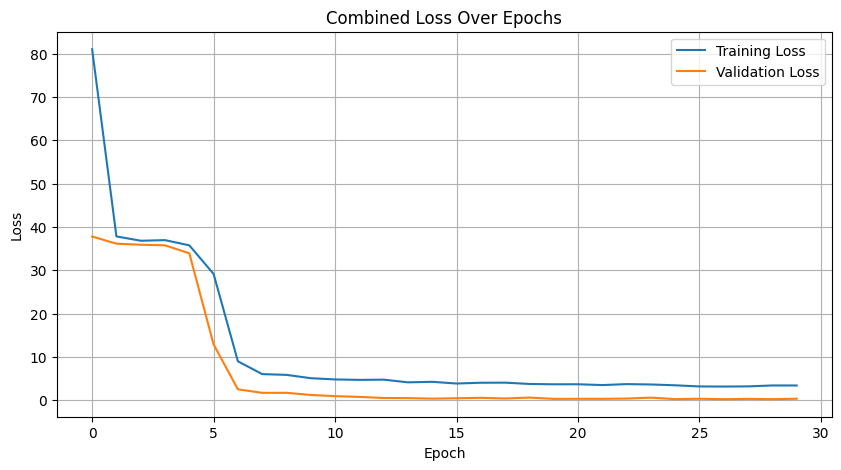

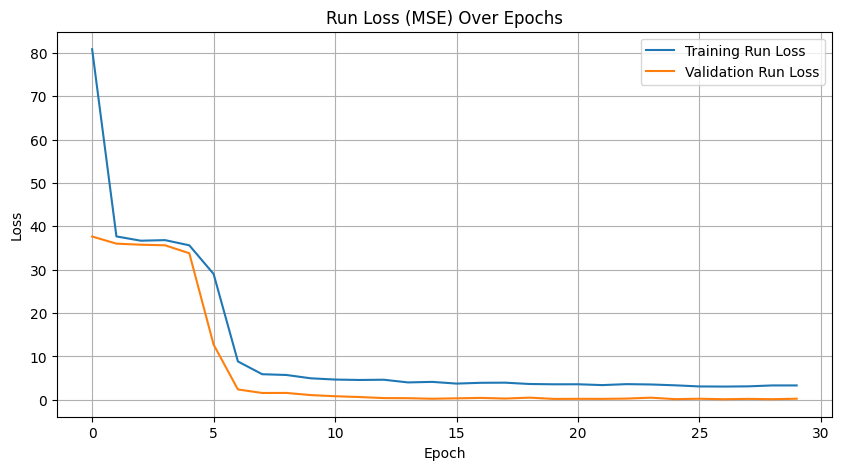

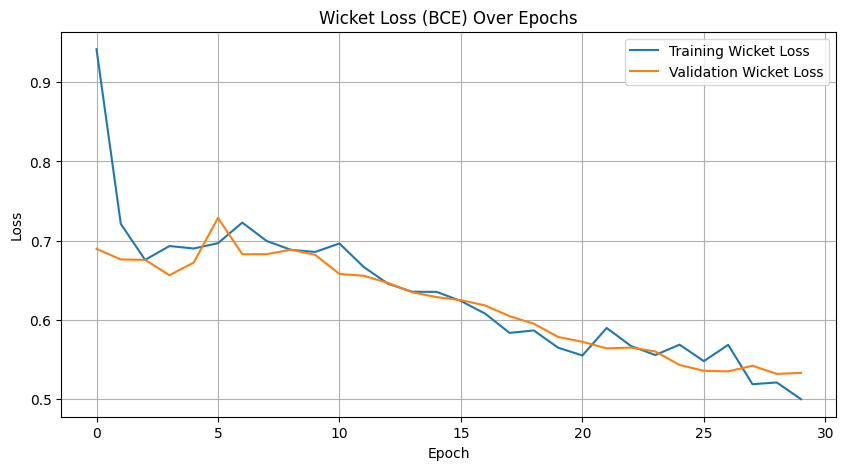

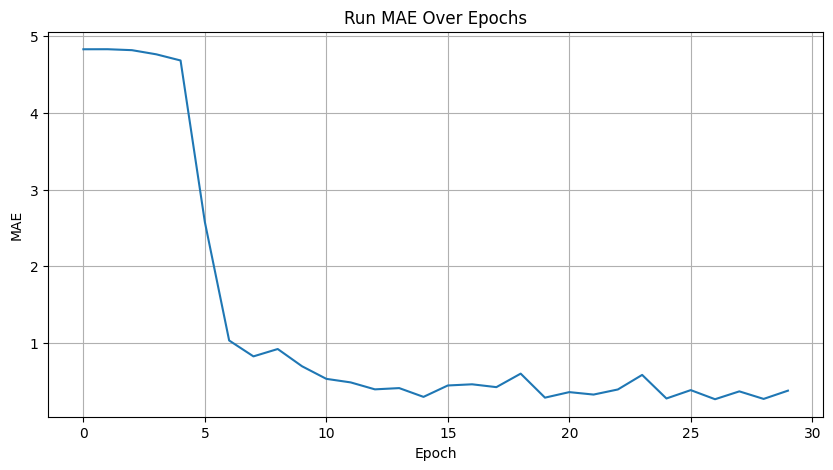

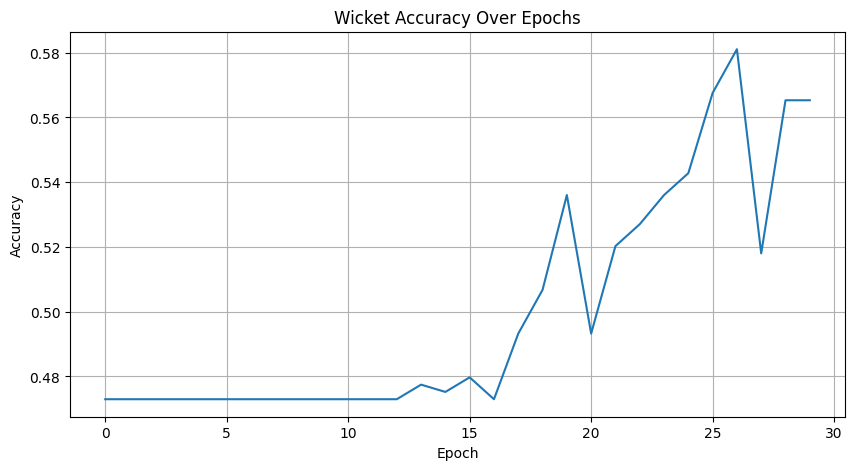

In [10]:
if __name__ == "__main__":
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Run the main function to train or load the model
    model, train_loader, test_loader, data = main(
        use_cached_data=True,  # Use preprocessed data if available
        train_new_model=True,  # Train a new model (set to False to load existing)
        sequence_mode=True     # Use sequence mode for prediction
    )